In [1]:
from lanlab import Text,Batch,Sequential,Question
from lanlab import load,save
from lanlab import GPT35_0301,GPT35
from lanlab import Module,BatchedModule

import os

### Load the Datasets

In [2]:
question_data = load("inputs/new_crt.json").repeat(10,axis=1) #Each question is asked 10 times (100 in the paper)
example_data = load("inputs/new_crt_example.json").repeat(10,axis=1)

### Make the pipelines

In [3]:
#AutoCorrection using ChatGPT
class AutoCorrect(BatchedModule):
    def __init__(self,label_index=0):
        super().__init__()
        self.label_index = label_index
    def _run(self,seq):
        #Prepare the prompt
        question = seq[self.label_index]
        answer = seq[self.label_index+1]
        prompt = Text('You are a professor and just gave an exam. Here is the question asked')+question+Text('Here is the answer one of your student wrote')+answer+Text('Your goal now is to mark the answer as either correct, intuitive or other. The correct answer is "{}", the intuitive answer is "{}" and the answer is other if it is not one of these two. Is this answer correct, intuitive or other ? Please write "c" if the answer is correct, "i" if it is intuitive and "o" if it is other.'.format(question['info']['keywords']['correct'][0],question['info']['keywords']['intuitive'][0])) #Some prompt engineering
        #Ask ChatGPT to classify the answer
        prompt_and_label = GPT35().configure(temperature=0)(prompt)
        #Return the answer
        label = prompt_and_label[-1]['text']
        if 'c' in label or 'correct' in label:
            return seq + Text('c')
        elif 'i' in label or 'intuitive' in label:
            return seq + Text('i')
        else:
            return seq + Text('o')

In [4]:
model = GPT35_0301().configure(max_tokens=256) #Context long enough to let the model reason if necessary

vanilla_pipeline = Sequential(model,AutoCorrect(0))
example_pipeline = Sequential(model,AutoCorrect(2))
reasoning_pipeline = Sequential("Let's think step by step",model,AutoCorrect(0))

### Get the results (and correct them)

In [5]:
#Vanilla results
crt_vanilla = vanilla_pipeline(question_data,os.path.join('data','crt',model.name,'vanilla.json'))
crt_example = example_pipeline(example_data,os.path.join('data','crt',model.name,'example.json'))
crt_reasoning = reasoning_pipeline(question_data,os.path.join('data','crt',model.name,'reasoning.json'))

### Plot the results

In [ ]:
#Plot the results
import matplotlib.pyplot as plt
import numpy as np

def plot_results(crt_result):
    correct = [[crt_result[i,j][-1]['text'] == 'c' for j in range(crt_result.shape[1])] for i in range(crt_result.shape[0])]
    intuitive = [[crt_result[i,j][-1]['text'] == 'i' for j in range(crt_result.shape[1])] for i in range(crt_result.shape[0])]

    correct_means = [sum(correct[i])/len(correct[i]) for i in range(len(correct))]
    #correct_stds = [np.std(correct[i]) for i in range(len(correct))]

    intuitive_means = [sum(intuitive[i])/len(intuitive[i]) for i in range(len(intuitive))]
    #intuitive_stds = [np.std(intuitive[i]) for i in range(len(intuitive))]

    plt.figure(figsize=(10,5))
    plt.bar(np.arange(len(correct_means)),correct_means,color='limegreen')#,yerr=correct_stds)
    plt.bar(np.arange(len(intuitive_means)),intuitive_means,bottom=correct_means,color='dodgerblue')#,yerr=intuitive_stds)
    plt.xticks(np.arange(len(correct_means)),['Q{}'.format(i+1) for i in range(len(correct_means))])
    plt.legend(['Correct','Intuitive'])
    plt.ylabel('Proportion')
    plt.xlabel('Question')
    plt.title('Results')
    plt.show()

#### Vanilla

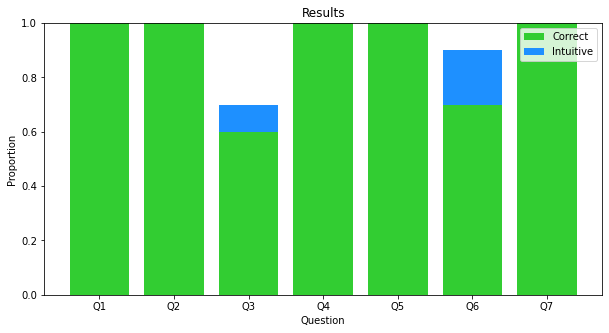

In [ ]:
plot_results(crt_vanilla)

#### Example

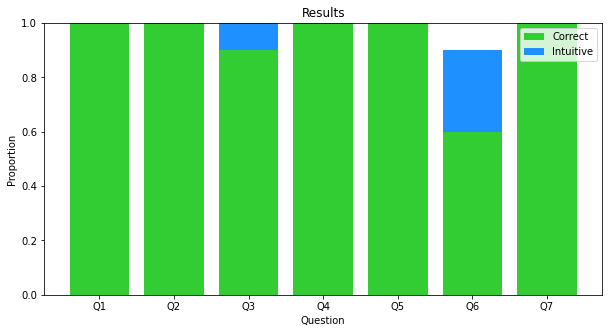

In [ ]:
plot_results(crt_example)

#### Reasoning

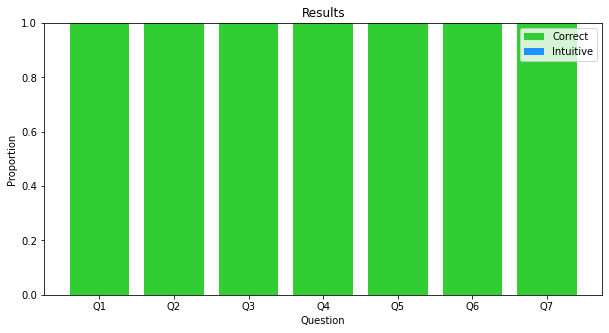

In [ ]:
plot_results(crt_reasoning)